# Proof of Concept: Detection of Defective Carton/Product Box using ML

#### Lee Xuan Hong (mentored by Gan Hong Yee)

## Problem Statement
Quality assurance provides a competitive advantage to companies, and a key component of quality assurance is visual inspection - using the naked eye to spot defects/issues with products. However, this old-fashioned method of manual inspection comes with inherent human limitations - employees can fail to identify defects due to time pressure, carelessness, laziness, or tiredness, amongst other things. Previous research has shown that for most visual inspection tasks, missed defects typically range from 20%-30% (Drury & Fox, 1975). As a result, defects are not always detected early on and may slip downstream, where the impacts are more severe and costs incurred are higher (wasted work done, RMA, customer complaints, reputational risks, etc. ). This is because according to the "1-10-100 Rule", costs balloon by a factor of 10 each time a defect escapes detection throughout the process flow (Kakde, 2020). 

Therefore, this project seeks to come up with a proof of concept for automating the carton/product box visual inspection process @ DCA's inbound receiving using machine learning (ML). Specifically, this project will train a ML model that is able to differentiate between damaged cartons/product boxs versus those in good condition, thereby alerting the user when a damaged carton/product box is detected. 

Unlike humans, machines do not get tired, lazy, distracted, or suffer from expectation bias. Therefore, replacing manual inspection with ML visual inspection will bring benefits such as: improving error detection rate and accuracy, reducing human errors, saving time and resources.

~*note: "shipping carton" and "product box" can be used interchangeably in this project because both are outer packaging that serves a similar purpose, hence it will make no difference to our trained model*

## Executive Summary 
xxxx
#### Contents: 
1. Image data collection and EDA
2. Image data cleaning
3. Image preprocessing
4. Model training and testing
5. Evaluation and conclusion


## 1. Image Data Collection and Exploratory Data Analysis
Images of good shipping cartons (i.e. no defects) and bad shipping cartons (i.e. defective) were collected from both external and internal sources. External sources refer to online websites providing free-to-use images while internal sources refer to IFX LOG Quality team's own archive of shipping carton/product box images. 
#### 1a. Webscraping
Webscraping is the process of harvesting data from websites. Images were scraped from the following websites: (refer to *1_webscraping.ipynb* for full list of urls)<br>
https://www.istockphoto.com<br>
https://www.freepik.com<br>
https://depositphotos.com<br>
https://www.dreamstime.com<br>
https://www.shutterstock.com

Various search keys were used on these websites to return image results for both good and bad carton boxes, such as: *damaged cardboard boxes, cardboard boxes, shipping carton,* etc.

Webscraping was performed using the python library Beautiful Soup. More information can be found in the *1_webscraping.ipynb* notebook.

A total of __1368__ good shipping carton images and __729__ bad shipping carton images were scraped. 

#### 1b. Internal Archive
IFX also has an archive of shipping carton/product box images documented from the numerous 8D cases throughout the years. From this internal archive, we were able to obtain __295__ good shipping carton images and __1090__ bad shipping carton images.

#### 1c. EDA
There is slight class imbalance, as the split between bad and good is : __1663/1819__, or __48/52__ in percentages. We will balance out the classes using SMOTE subsequently after we clean the data.


## 2. Image Data Cleaning
#### 2a. Removing corrupt images
The first step of image data cleaning is removing corrupt images. A simple piece of code is run to identify corrupted image files (if any) which will cause an error when we train our model subsequently. After identifying the corrupted image files, we then delete those image files. 

More information on the code can be found in in *2a_removing_corrupted.ipynb* notebook. Reference was taken from: https://www.codegrepper.com/code-examples/python/python+check+if+image+is+corrupted .

28 corrupted images were removed.
#### 2b. Removing duplicate images with Hashing
The second step of image data cleaning is removing duplicate images. Duplicate images will cause the model to form a bias during training. Hence, duplicate images was removed in this project. 

Code for removing duplicate images can be found in *2b_removing_duplicates.ipynb* notebook. Reference was taken from: https://www.youtube.com/watch?v=AIyJSGmkFXk

283 duplicate images were removed. 
#### 2c. Removing irrelevant images using YOLOv3 transfer learning
##### Rationale
Some of the scraped images are totally irrelevant (i.e. they contain no boxes at all). To manually scroll through these images to check for irrelevant ones would be very time consuming, especially if we have a huge image dataset. Hence, we made use of transfer learning and retrained the YOLOv3 model with a custom dataset of shipping cartons/product boxes, to train it to detect shipping cartons/product boxes. In other words, we are using machine learning 2 times: 1st time is to help us clean the webscraped images by removing those irrelevant images without shipping cartons at all, 2nd time is to help us detect defective cartons, which is the main objective of this project. 

Code can be found in *2c_yolo_model_evaluation.ipynb* notebook in "2c_train_yolo_to_clean_scraped_images\\yolo_custom_detection" folder. This step is heavily referenced from the instructions and code laid out in this tutorial: https://pysource.com/2020/04/02/train-yolo-to-detect-a-custom-object-online-with-free-gpu/ .

##### Training the model
To train the model, we prepared 100 webscraped images of shipping cartons/product boxes and labelled them manually using an external software called LabelImg (see folder "*yolo_labelled_images_final*"). As the training of the Yolov3 model takes a very long time, we made use of the free online GPU offered by Google Colab to speed up the training process. "*Train_YoloV3*" contains the code that we ran on Google Colab to train the Yolov3 model. The model was trained for 1000 iterations.

##### Testing the model
To test the model, we prepared 50 webscraped images (25 with cartons in it and 25 without) inside a folder named "yolo_test_images_final". We will test the model on this dataset and plot a confusion matrix. A confusion matrix is used because 
we want to pay attention to the false negative and false positive rates, apart from the overall accuracy rate. A high false negative rate will result in deletion of relevant images as the model wrongly predicts that there are no carton box in the images; while a high false positive rate would mean that many irrelevant images would not be captured as the model wrongly predicts that there are carton boxes in the images.

Our objective, apart from maximising the correct predictions (true positives and true negatives), is to __minimise false negatives__ (i.e. images contain cartons but model detects/predicts no carton) because we do not want to end up deleting relevant images. We are __more tolerant of false positive__ (i.e. images do not contain cartons but model detects/predicts carton is present) because these can be sieved out when we do the manual check afterwards for the accuracy of the labels.<br> *Note: since this Yolov3 model is meant to help us clean the webscraped images, webscraped images are thus used in both the training and testing datasets.*

##### Results of testing
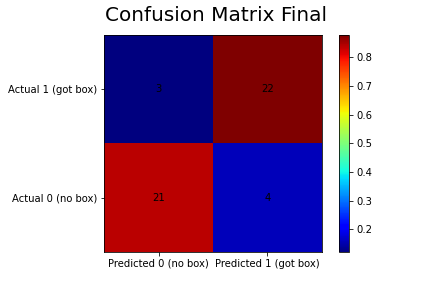
From the first row of the confusion matrix shown above, it can be seen that:<br>
-of all images that are actually relevant (25), the model predicted relevant (correctly) for 22 of them. This gives us a <b>true positive/recall rate</b> of <u>22/25 = 88%</u>. <br> 
-of all images that are actually relevant (25), the model predicted irrelevant (wrongly) for 3 of them. This gives us a <b>false negative rate</b> of <u>3/25 = 12%</u>. <br><br>
From the second row, it can be seen that:<br>
-of all images that are actually irrelvant (25), the model predicted irrelevant (correctly) for 21 of them. This gives us a <b>true negative rate</b> of <u>21/25 = 84%</u>.<br>
-of all images that are actually irrelvant (25), the model predicted relevant (wrongly) for 4 of them. This gives us a <b>false positive rate</b> of <u>4/25 = 16%</u>.<br><br>
Overall, the <b>accuracy rate</b> is <u>(21+22)/50 = 86%</u>, which is acceptable.<br>

##### Applying the YOLOv3 model
A total of 633 out of 1790 scraped images was deemed to be irrelevant (i.e. does not contain carton boxes) by the model and hence removed from the dataset. After removal of these irrelevant images, we are thus left with 1157 scraped images. 

#### 2d. Manual inspection of scraped images 
After the first cut cleaning performed by the Yolov3 model, we then perform a 2nd manual inspection of the scraped images to check for the accuracy of the labels for the scraped images (i.e. ensure that the scraped images are in the correct folder: images with defective carton box are in the "webscraped_bad" folder, vice versa). At the same time, we can check for any irrelevant images missed out by the Yolov3 model in the previous step and remove them.

After manual inspection and deletion, we are left with 867 scraped images (262 bad, 605 good).

## 3. Image pre-processing
#### Class count balance
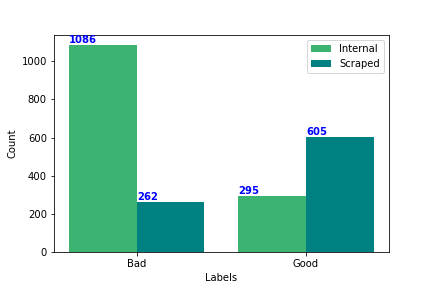
After webscraping and cleaning of the images, we are left with a dataset of 1348 bad carton box images and 900 good carton box images (total 2248 images), which is a 60/40 split. While this slight imbalance in class count is usually not a concern (see: https://machinelearningmastery.com/what-is-imbalanced-classification/), we will still be balancing the class count during training phase using Synthetic Minority Oversampling Technique (SMOTE).
#### Train-Test split
Images are currently located in different subfolders within the 'good_bad_carton_images' folder: 'internal_bad', 'internal_good', 'webscraped_bad', 'webscraped_good'. Stratified train test split was performed to ensure the images in the train and test set are representative of the different types and class of images. The resulting train-test split obtained is: 76/24; 1810 training images/438 testing images.

A new directory 'train_test_dataset' was also created, with subfolders 'train' and 'test', to house the images according to their train-test split for clearer visualisation.
#### Resizing training images and converting to numpy arrays
As we intend to use the VGG16 model for transfer learning in the training phase later, images are resized to 224x224 (the size required by the VGG16 model). Training images are also converted to numpy arrays to prepare them for SMOTE.  
#### SMOTE to balance class count
Currently, of the 1810 training images, 1095 are "bad" and 715 are "good". There is slight imbalance of class count as ~60% of images belong to the "bad" class while ~40% belong to the "good" class. 

SMOTE is thus performed to balance the class count. SMOTE is a statistical technqiue of synthetic oversampling that generates new instances for the minority class. These new instances are not just copies of existing minority cases, but rather they are created by selecting a minority case at random and then combining its features with its k nearest neighbours. 

After performing SMOTE, we obtain an increase in "good" training images from 715 to 1095, equalling that of "bad" training images. Therefore, the total training images increased from 1810 to 2190 and the training class count is now balanced.  

## 4. Model training and testing
We trained and tested several model versions to find out which is the best model (i.e. returns the highest test accuracy). The test accuracy of each model are listed below:
1. VGG16 Transfer Learning with data augmentation, mean subtraction using training set, train-val-test split: <u>86.758%</u>
2. VGG16 Transfer Learning without data augmentation, mean subtraction using training set, train-val-test split: <u>84.932%</u>
3. Baseline CNN model
4. Baseline RNN model

#### 4.1 VGG16 Transfer Learning with data augmentation
For this binary classification image recognition project, we decided to use the VGG-16 model for transfer learning. Transfer learning is essentially the reuse of a pre-trained model on a new problem. Using transfer learning has huge benefits: reduced training time, improved model performance (accuracy), does not require huge amounts of data. The VGG16 model is a model pre-trained on ImageNet's dataset (14 million images) using CNN architecture, developed by researchers from Oxford University. It won the ISLVR image classification competition in 2014 and is considered to be one of the best vision model architecture till date. 

Transfer learning is done by first loading the VGG16 model, then removing the fully connected layers from the output-end of the model, and replace with new fully connected layers that will learn to interpret the features extracted from the model and make a binary classification (i.e. "good carton box" or "bad carton box").
##### Data augmentation to increase dataset size
In this model version, data augmentation is performed. Data augmentation is a technique for increasing dataset size and diversity through making random transformations/modifications to the original images (rotating images, shift left, shift right, etc.) to create new images. The new transformed images need not be stored on our desktop memory, but can be generated on the fly and fed to the model for training and testing. However, for visualisation purposes, I have specified a folder to store the augmented images. A total of 24,136 augmented images were generated and fed to the model for training. 
##### Featurewise centering of pixel images
Images are also centered featurewise using Keras' ImageDataGenerator API. Featurewise centering is a pixel scaling method where the mean pixel value across the entire training dataset is calculated and then subtracted from each image. This is done to center the data around zero mean for each channel (R,G,B), so that the gradients do not go out of control. The code for this is located in "*4_model_training_testing.ipynb*" . 
##### Diagnostic learning curve
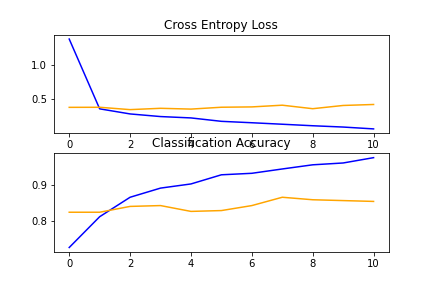
The graph above shows the diagnostic learning curve for our model with data augmentation.
#### 4.2 VGG16 Transfer Learning without data augmentation